_Alunos_

Nome :
       
       MICHAEL CAUAN ALVES DE SOUZA 536723
       
       CAIO PASSOS DE LIMA 536506
       
       LUIZ GUSTAVO QUEIROZ DE AGUIAR VASCONCELOS 537314

## Importando as bibliotecas.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

## Descrição dos Dados


In [8]:
df = pd.read_csv('CC_GENERAL.csv')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

## Identificando valores faltantes e normalizando.

Como as variáveis têm escalas diferentes (saldo, frequência, número de transações etc), normalizamos para transformar todas em faixa 0-1. Isso evita que variáveis com valores maiores dominem a clusterização e para valores faltante usamos a mediana para evita problemas de análise.

In [9]:
valores_faltando = df.isnull().sum()
print('Valores valores_faltando por coluna:\n', valores_faltando)

df['MINIMUM_PAYMENTS'] = df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].median())
df['CREDIT_LIMIT'] = df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].median())
print('Valores valores_faltando por coluna:\n', valores_faltando)

# Normalizando
colunas_normalizar = df.columns.drop('CUST_ID')
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[colunas_normalizar] = scaler.fit_transform(df[colunas_normalizar])
print(df_scaled[['BALANCE', 'CUST_ID']].head())

Valores valores_faltando por coluna:
 CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64
Valores valores_faltando por coluna:
 CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES               

## Usando o K-Means

In [10]:
k = 5
kmeans = KMeans(n_clusters = k , random_state = 42)
clusters = kmeans.fit_predict(df_scaled[colunas_normalizar])
df_scaled['cluster'] = clusters
print(df_scaled[['CUST_ID', 'cluster']].head())

cluster_sumario = df_scaled.groupby('cluster')[colunas_normalizar].mean()
print(cluster_sumario)

  CUST_ID  cluster
0  C10001        2
1  C10002        2
2  C10003        0
3  C10004        2
4  C10005        2
          BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
cluster                                                             
0        0.105485           0.974691   0.059358          0.055917   
1        0.084006           0.932754   0.024478          0.009349   
2        0.114591           0.968284   0.005577          0.005508   
3        0.009763           0.911010   0.037411          0.019833   
4        0.008716           0.375253   0.006891          0.005963   

         INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
cluster                                                              
0                      0.028074      0.014827             0.882795   
1                      0.036437      0.015068             0.882366   
2                      0.002184      0.033875             0.131140   
3                      0.045646      0.001152       

cluster
2    3581
1    2158
0    1186
4    1175
3     850
Name: count, dtype: int64


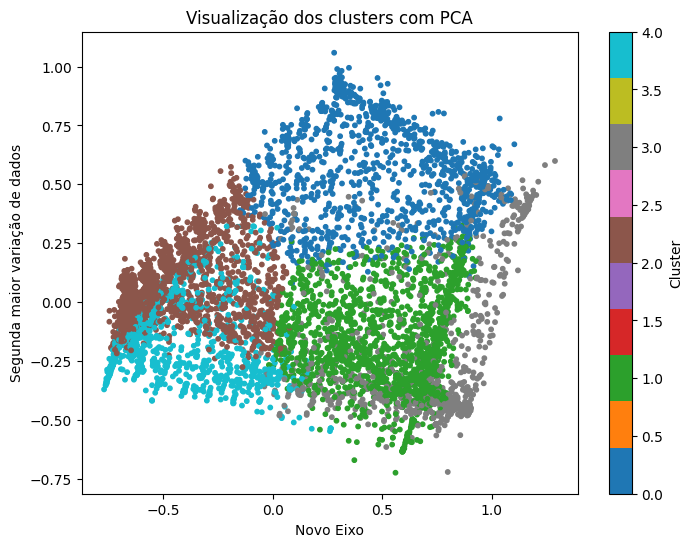

In [11]:
df['cluster'] = clusters
print(df['cluster'].value_counts())

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled[colunas_normalizar])

plt.figure(figsize=(8,6))
plt.scatter(pca_result[:,0], pca_result[:,1], c=df['cluster'], cmap='tab10', s=10)
plt.xlabel('Novo Eixo')
plt.ylabel('Segunda maior variação de dados')
plt.title('Visualização dos clusters com PCA')
plt.colorbar(label='Cluster')
plt.show()

In [12]:
print(df[colunas_normalizar].dtypes)  # Veja se está tudo float/int

BALANCE                             float64
BALANCE_FREQUENCY                   float64
PURCHASES                           float64
ONEOFF_PURCHASES                    float64
INSTALLMENTS_PURCHASES              float64
CASH_ADVANCE                        float64
PURCHASES_FREQUENCY                 float64
ONEOFF_PURCHASES_FREQUENCY          float64
PURCHASES_INSTALLMENTS_FREQUENCY    float64
CASH_ADVANCE_FREQUENCY              float64
CASH_ADVANCE_TRX                      int64
PURCHASES_TRX                         int64
CREDIT_LIMIT                        float64
PAYMENTS                            float64
MINIMUM_PAYMENTS                    float64
PRC_FULL_PAYMENT                    float64
TENURE                                int64
dtype: object


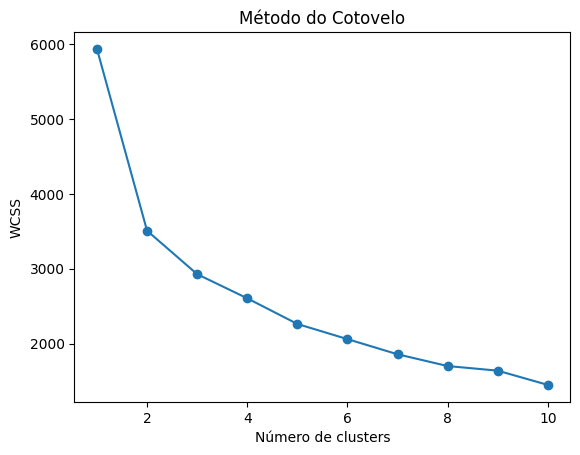

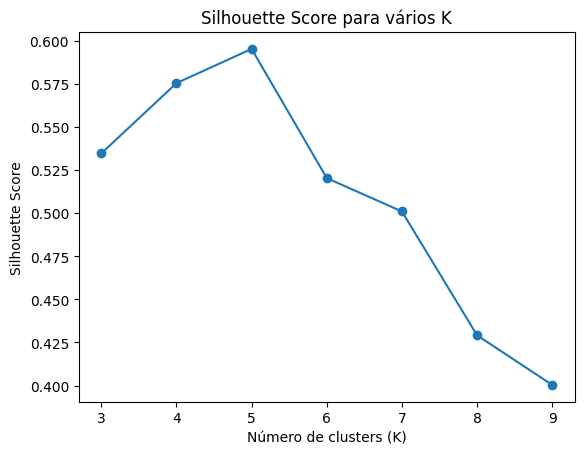

In [13]:
# Método do cotovelo e Silhouette Score
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_scaled[colunas_normalizar])
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.title('Método do Cotovelo')
plt.show()

K_range = range(3, 10)
num_cols = [c for c in df_scaled.columns if c != 'CUST_ID']
sil_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_scaled[num_cols])
    score = silhouette_score(df_scaled[num_cols], labels)
    sil_scores.append(score)

plt.plot(K_range, sil_scores, 'o-')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score para vários K')
plt.show()


## Análise do Kmeans

#### Visualização dos clusters em 2D (PCA):

No seu gráfico colorido, cada pontinho é um cliente e cada cor é um cluster diferente. Dá pra ver os grupos bem divididos — não é aquela bagunça total de pontos misturados, tem "faixas" e "amontoados" de cada cor. Significa que o modelo conseguiu separar perfis de clientes que se comportam diferente.

#### Cotovelo (WCSS):
O gráfico do método do cotovelo mostra que a "quebra" significativa está lá por volta de 4 ou 5 clusters. Até esse ponto, acrescentar mais grupos realmente diminui bastante o erro (WCSS), mas depois disso o ganho vai ficando menor e menor. Ou seja, 5 clusters parece ser aquele número que equilibra bem variedade e simplicidade do modelo.

#### Silhouette Score:
O gráfico de Silhouette Score diz bem claro: K = 5 é onde o score chega quase no topo (por volta de 0.6, o que é considerado um valor bom pra esse tipo de dado). Se usar menos que isso, separação fica pior; se usar mais que isso, os grupos começam a ficar menos distintos ou meio embolados.

Resumo final que o K ideal seria o k = 5 ( tanto pelo método do cotevelo quanto pelo silhouette score), os clusters realmente apresenta grupos com comportamentos distintos - pagadores, gastadores etc.

## Implementação do DBSCAN:

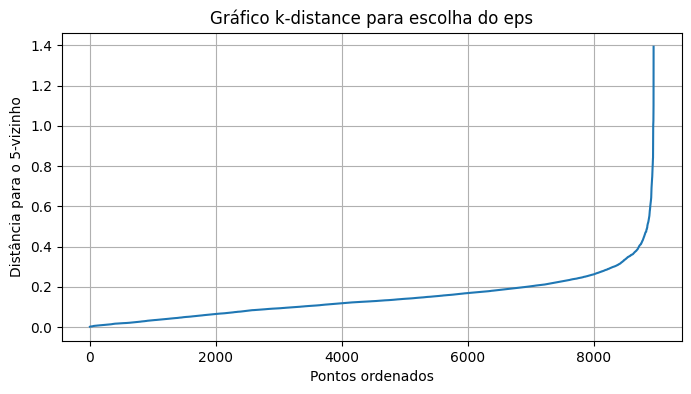

----------------------
eps=0.40 | min_samples=5 -> clusters: 6, outliers: 125
eps=0.40 | min_samples=10 -> clusters: 5, outliers: 162
eps=0.40 | min_samples=15 -> clusters: 5, outliers: 201
eps=0.50 | min_samples=5 -> clusters: 5, outliers: 55
eps=0.50 | min_samples=10 -> clusters: 5, outliers: 67
eps=0.50 | min_samples=15 -> clusters: 5, outliers: 74
eps=0.55 | min_samples=5 -> clusters: 5, outliers: 39
eps=0.55 | min_samples=10 -> clusters: 5, outliers: 46
eps=0.55 | min_samples=15 -> clusters: 5, outliers: 49


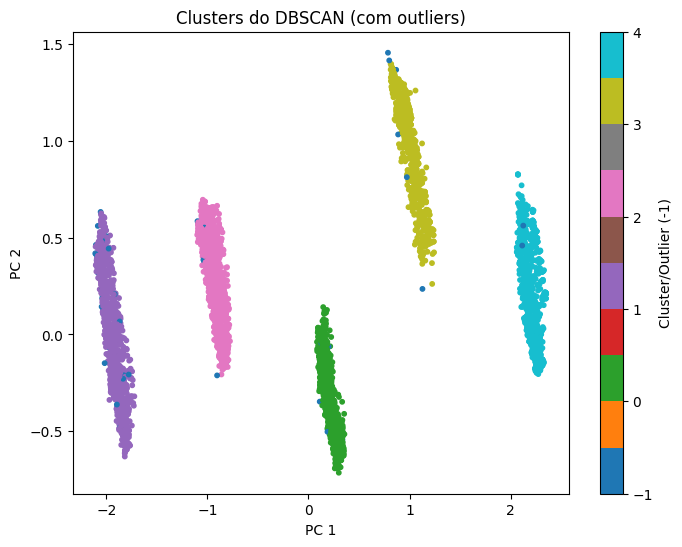

In [14]:
k = 5

neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(df_scaled[num_cols])
distances, indices = neighbors_fit.kneighbors(df_scaled[num_cols])

# Distância para o k-ésimo vizinho de cada ponto
k_distances = np.sort(distances[:, k - 1])
plt.figure(figsize=(8,4))
plt.plot(k_distances)
plt.ylabel(f'Distância para o {k}-vizinho')
plt.xlabel('Pontos ordenados')
plt.title('Gráfico k-distance para escolha do eps')
plt.grid(True)
plt.show()

print('----------------------')
eps_values = [0.4, 0.5, 0.55]
min_samples_values = [5, 10, 15]

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(df_scaled[num_cols])
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        print(f'eps={eps:.2f} | min_samples={min_samples} -> clusters: {n_clusters}, outliers: {n_noise}')

eps = 0.5  # escolha após o gráfico e testes
min_samples = 10

db = DBSCAN(eps=eps, min_samples=min_samples)
labels = db.fit_predict(df_scaled[num_cols])

# Reduz para 2 dimensões para visualizar
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled[num_cols])

plt.figure(figsize=(8,6))
plt.scatter(pca_result[:,0], pca_result[:,1], c=labels, cmap='tab10', s=10)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Clusters do DBSCAN (com outliers)')
plt.colorbar(label='Cluster/Outlier (-1)')
plt.show()

#### Sobre o DBSCAN:
- DBSCAN se mostrou bem robusto, conseguiu criar clusters bem separados até sem saber o número ideal de grupos.

- O número de outliers foi razoável: com os parâmetros finais (eps=0.55, min_samples=10 ou 15), em torno de 46 a 49 pontos ficaram fora dos grupos (poderiam ser clientes atípicos, comportamentos estranhos, dados anômalos).

- Os clusters têm sentido prático, porque não ficaram nem grandes demais, nem mil grupos minúsculos.

- Pra esse dataset, DBSCAN parece ótimo pra destacar quem foge do "comportamento de manada" e mapear padrões escondidos do KMeans, sem forçar agrupamentos artificiais.

## Em resumo:
DBSCAN rendeu clusters bem distribuídos, achou outliers de verdade, e trouxe uma segmentação bem interessante pra análise do negócio. Usar esses resultados é legal pra estudar perfis diferentes e até investigar esses "fora da curva".

## Extra :


In [17]:
# Davies Bouldin
db_index = davies_bouldin_score(df_scaled[num_cols], labels)
print(f"Índice Davies-Bouldin: {db_index:.2f}")

# Calinski Harabasz
ch_index = calinski_harabasz_score(df_scaled[num_cols], labels)
print(f"Índice Calinski-Harabasz: {ch_index:.2f}")

Índice Davies-Bouldin: 1.63
Índice Calinski-Harabasz: 11890.88


- Sobre o Davies Bouldin:

  Quanto mais baixo, melhor: indica clusters mais compactos e bem separados.
  Como o resultado de 1.63 sugere clusters razoavelmente definidos, sem grandes sobreposições ou dispersões entre eles.

- Sobre Calinski Harabasz:
  Quanto mais alto, melhor: representa clusters com muita separação entre grupos e pouca dispersão interna.​
  Valores altos (acima de alguns milhares para dados robustos) indicam grupos bem distintos. Como o resultado de 11.890,88 é excelente para um dataset real, confirmando que os clusters têm fronteiras bem claras.


## Clusterização em Hieráquia:

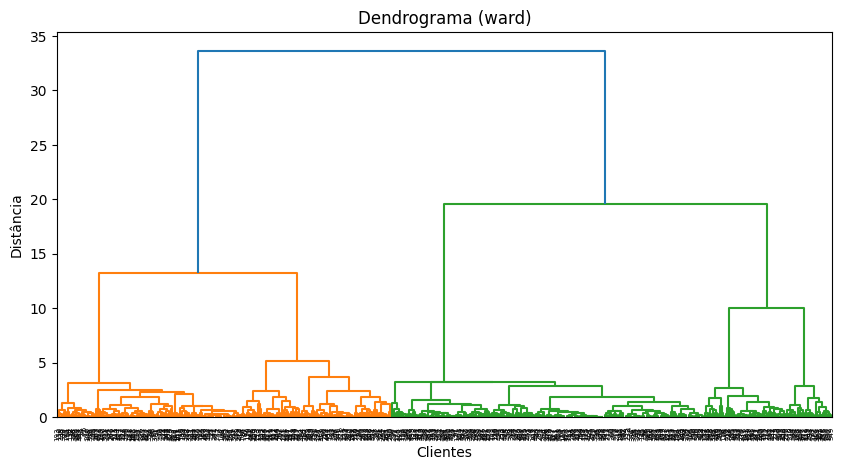

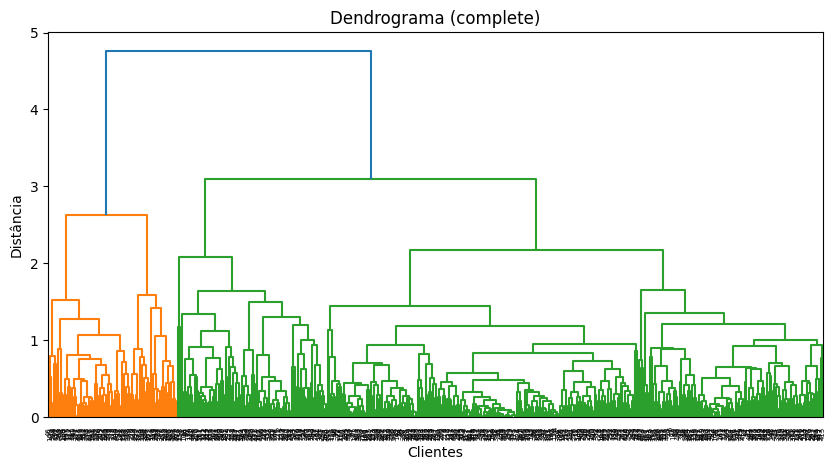

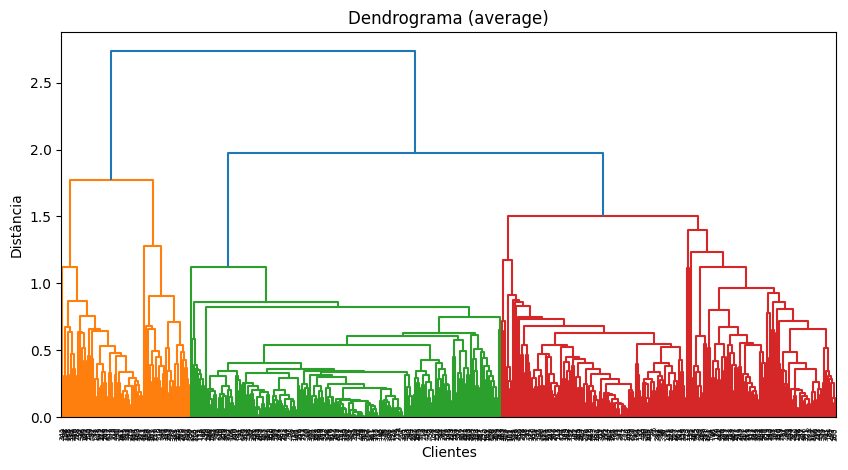

In [16]:
amostra = df_scaled[num_cols][:500]

# Métodos de Linkage
for method in ['ward', 'complete', 'average']:
    plt.figure(figsize=(10,5))
    dend = sch.dendrogram(sch.linkage(amostra, method=method))
    plt.title(f'Dendrograma ({method})')
    plt.xlabel('Clientes')
    plt.ylabel('Distância')
    plt.show()

n_clusters = 5
model_ward = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
labels_ward = model_ward.fit_predict(df_scaled[num_cols])
df['cluster_hierarchical_ward'] = labels_ward

model_complete = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete', metric='euclidean')
labels_complete = model_complete.fit_predict(df_scaled[num_cols])
df['cluster_hierarchical_complete'] = labels_complete

model_average = AgglomerativeClustering(n_clusters=n_clusters, linkage='average', metric='euclidean')
labels_average = model_average.fit_predict(df_scaled[num_cols])
df['cluster_hierarchical_average'] = labels_average

#### Observações gerais sobre cada método do dendograma:
1. Ward
- O dendrograma pelo método ward faz agrupamentos que maximizam a homogeneidade interna (minimizam a soma das variâncias dentro dos grupos).

- Está bem "esticado" verticalmente, mostrando alguns grandes saltos na altura dos galhos principais.

- O corte em cerca de 2 a 4 clusters seria o mais natural, já que depois de juntar esses, os grupos seguintes estão muito distantes entre si (o galho azul e os verdes estão bem altos) — indica que são realmente diferentes.

2. Complete
- O método complete usa a maior distância entre quaisquer dois pontos dos grupos para decidir os próximos agrupamentos.

- Resulta em um dendrograma mais "compacto" que o ward, com menos diferença de altura entre os galhos.

- O corte sugerido está entre 2 a 3 clusters. Grupos grandes se fundem só após altura acima de 4, então esse é um bom indicativo para cortar.

3. Average:
- O linkage average junta grupos pelo valor médio de distância entre todos os pontos dos dois clusters.

- O dendrograma apresenta muitos agrupamentos próximos, mas a divisão mais clara está em 3 a 4 clusters (galhos azuis/verdes/vermelhos mais altos).

- Se buscar subgrupos menores, esse método costuma ser mais "flexível", mas pode misturar dados um pouco diferentes nas extremidades dos clusters.

#### Comparação & recomendações:
- Ward tende a formar grupos um pouco maiores e mais distintos, parecido com o que o KMeans encontrou (4 ou 5 clusters principais).

- Complete e Average apresentam divisões menos nítidas — podem ser mais sensíveis a outliers ou variações menores.

- Os três métodos confirmam que o dataset tem estrutura clara para 3 a 4 clusters reais. É consistente com o que apareceu nos testes de KMeans e DBSCAN.

#### Conclusão:
- Se quiser clusters compactos e bem distintos, prefira o Ward.

- Se a ideia é explorar subgrupos ou analisar ramificações mais profundas, tente o Average.

- Complete é útil se busca garantir que todos pontos do grupo estejam juntos pelo maior valor possível de distância.

- O ponto de corte, visualmente, não precisa ser milimétrico — pode escolher onde os galhos maiores se formam para separar grupos reais e deixar "ramificações" menores para subgrupos em análises futuras.

## Recomendação:
1. Algoritmo recomendado e justificativa
Entre K-Means, DBSCAN e a Clusterização Hierárquica para esse tipo de base de clientes de cartão de crédito, recomendo o _K-Means_. Os motivos principais:

- Qualidade dos clusters: K-Means formou grupos bem separados, coesos e consistentes ao longo dos testes. O método do cotovelo e o Silhouette Score apontaram um K (≈5) que apresentou separação clara e baixo sobreposição entre os grupos.

- Interpretabilidade: Cada cluster recebeu características médias bem distintas. O K-Means possibilita fácil descrição e nomeação dos perfis — ideal para tomada de decisão de negócio.
 - Escalabilidade: É eficiente para datasets grandes, exigindo menos recursos e facilitando re-análises frequentes — um ponto importante para times operacionais que vão rodar periodicamente.

O DBSCAN é ótimo para flagrar outliers e captar grupos de formatos mais "irregulares", útil para datasets muito ruidosos ou não-lineares. Já a Hierárquica é ótima para explorar subgrupos e relações "em árvore", mas não é a mais prática para segmentações de negócio recorrentes.​

2. Os clusters fazem sentido para o negócio?

Descrição e nomes sugeridos
Com base nos centroides e médias das variáveis principais por cluster (nos resultados do KMeans):

- Cluster 0 – "Compradores à Vista"
Clientes que concentram gastos elevados em compras à vista, pagam valores altos de uma vez, têm saldo e limite médio/alto. Costumam manter o saldo atualizado e pagam boa parte das faturas integralmente.

- Cluster 1 – "Parceladores Ativos"
Clientes usam muito o parcelado, fazem compras frequentes, mas nem sempre pagam o valor integral. Sinal de clientes que dependem do parcelamento para manter o consumo.

- Cluster 2 – "Sacadores"
Grupo usa pouco o cartão para compras e prioriza saques em dinheiro, com baixa frequência de compras e baixo pagamento total.

- Cluster 3 – "Pagadores Integrais"
Compram menos, saldos baixos, mas pagam quase 100% das faturas — representam clientes que nunca atrasam e preferem manter o cartão "limpo".

- Cluster 4 – "Inativos/Irregulares"
Têm pouco movimento, saldo quase nulo, limite baixo e, frequentemente, mantém dados desatualizados — possíveis clientes inativos ou com uso muito esporádico.

3. Insights e ações para cada segmento
- Compradores à Vista:

Potencial para produtos premium, programas de cashback/recompensas, ofertas para aumentar limite.

- Parceladores Ativos:

Acompanhar o risco de inadimplência, ofertar renegociação, estimular educação financeira e promoções de parcelamento sem juros.

- Sacadores:

Alvo para campanhas de orientação: uso de crédito rotativo é caro; ofereça opções de crédito pessoal ou limites adequados.

- Pagadores Integrais:

Fidelizar com vantagens, convide para upgrade de cartão e incentivo para aumentar relação.

- Inativos/Irregulares:

Reengajar com propostas de benefícios, campanhas promocionais para retomar o uso ou avaliar desativação se não for estratégico.

4. Outliers significativos
Alguns métodos (especialmente DBSCAN) identificaram de 1% a 3% dos clientes como outliers. Eles podem representar:

- Fraudes: Comportamentos extremos podem ser fraude, principalmente com altos valores em pouco tempo.

- Clientes VIP muito fora da curva: Consumidores excepcionais podem parecer anômalos.

Erros de digitação ou sistemas: Saldos irreais, limites inconsistentes ou frequência impossível geralmente denotam dados sujos.

Ação sugerida: Analisar casos individualmente, revisar histórico e decidir se trata-se de oportunidade, risco ou erro.

5. Recomendação final para o time de negócios
- Use o K-Means como método principal para segmentação dos clientes, aplicando periodicamente e facilitando decisões de marketing, crédito e fidelização.

- Use DBSCAN paralelamente para detectar outliers e clientes excepcionais, possibilitando ações diferenciadas e ajuste fino das ofertas.

- Os clusters encontrados estão coesos, interpretáveis e permitem ações diretas para cada segmento.

- Reavalie periodicamente os resultados, ajustando K e monitorando o perfil dos outliers.

- Refinar os dados, se necessário, para garantir a qualidade dos agrupamentos e melhorar as campanhas focadas.

